# Multi Layer Perceptron

In [98]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix


## Carregando os dados

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df_all = pd.read_parquet("../../data/data_processed/participants/Participants_all.parquet")
df_all.head()

,pid,window_start,window_end,n_samples,duration_seconds,sex,age_group,label:Walmsley2020,label:Walmsley2020_enc,label:WillettsSpecific2018,label:WillettsSpecific2018_enc,label:WillettsMET2018,label:WillettsMET2018_enc,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,hour_sin,hour_cos
0,P001,2016-11-13 02:18:00,2016-11-13 02:18:05,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.468161,0.004565,-0.482334,-0.46669,-0.537512,0.006892,-0.548902,-0.533341,0.657518,0.003960,0.643077,0.673867,0.219195,0.288966,0.432345,0.940507,0.969787,-0.148480,-0.077644,0.275487,0.0,0.0,0.566406,0.824126
1,P001,2016-11-13 02:18:05,2016-11-13 02:18:10,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470069,0.006437,-0.482334,-0.46669,-0.537045,0.006771,-0.548902,-0.517780,0.657702,0.003627,0.643077,0.673867,0.221007,0.288463,0.432585,0.942055,0.970582,-0.108382,-0.028882,0.137541,0.0,0.0,0.566706,0.823920
2,P001,2016-11-13 02:18:10,2016-11-13 02:18:15,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469694,0.006162,-0.482334,-0.46669,-0.537947,0.007104,-0.548902,-0.533341,0.657764,0.003369,0.643077,0.673867,0.220650,0.289438,0.432665,0.942753,0.970944,-0.260468,-0.079268,0.204062,0.0,0.0,0.567005,0.823714
3,P001,2016-11-13 02:18:15,2016-11-13 02:18:20,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469287,0.005821,-0.482334,-0.46669,-0.537512,0.006962,-0.548902,-0.517780,0.657733,0.003567,0.643077,0.673867,0.220264,0.288967,0.432626,0.941857,0.970483,-0.243211,-0.092415,0.223157,0.0,0.0,0.567305,0.823508
4,P001,2016-11-13 02:18:20,2016-11-13 02:18:25,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470820,0.006896,-0.482334,-0.46669,-0.535333,0.005291,-0.548902,-0.517780,0.658226,0.002743,0.643077,0.673867,0.221719,0.286609,0.433269,0.941597,0.970350,-0.225457,-0.079250,0.230302,0.0,0.0,0.567604,0.823302


In [4]:
df_all.columns

Index(['pid', 'window_start', 'window_end', 'n_samples', 'duration_seconds',
       'sex', 'age_group', 'label:Walmsley2020', 'label:Walmsley2020_enc',
       'label:WillettsSpecific2018', 'label:WillettsSpecific2018_enc',
       'label:WillettsMET2018', 'label:WillettsMET2018_enc', 'x_mean', 'x_std',
       'x_min', 'x_max', 'y_mean', 'y_std', 'y_min', 'y_max', 'z_mean',
       'z_std', 'z_min', 'z_max', 'energy_x', 'energy_y', 'energy_z',
       'energy_total', 'magnitude_mean', 'corr_xy', 'corr_xz', 'corr_yz',
       'fft_dom_freq', 'fft_peak_power', 'hour_sin', 'hour_cos'],
      dtype='object')

In [5]:
# coluna da atividade alvo
TARGET = "label:WillettsSpecific2018"

In [67]:
label2enc = (
    df_all[["label:WillettsSpecific2018","label:WillettsSpecific2018_enc"]]
    .drop_duplicates()
    .set_index("label:WillettsSpecific2018")["label:WillettsSpecific2018_enc"]
    .sort_index()
    .to_dict()
)

In [68]:
label2enc

{'bicycling': 0,
 'household-chores': 1,
 'manual-work': 2,
 'mixed-activity': 3,
 'sitting': 4,
 'sleep': 5,
 'sports': 6,
 'standing': 7,
 'vehicle': 8,
 'walking': 9}

In [69]:
enc2label = {
    v: k for k, v in label2enc.items()
}

In [70]:
enc2label

{0: 'bicycling',
 1: 'household-chores',
 2: 'manual-work',
 3: 'mixed-activity',
 4: 'sitting',
 5: 'sleep',
 6: 'sports',
 7: 'standing',
 8: 'vehicle',
 9: 'walking'}

## Vamos escolher um participante para deixar de fora
    
Nosso teste inicial LOPO - Leave one participant out.

Ideia de que é mais dificil prever padrão de um participante que o modelo não viu.

Quando separamos por atividade e não por participante vamos testar o modelo em padrões de participantes já conhecidos pelo modelo.

Após testar modelo, vamos implementar versão mais robusta de treino e teste rodando várias vezes o modelo e deixando mais de um participante fora.

A decisão final foi deixar o P043 como primeira escolha de teste.

In [6]:
# -----------------------------------------------------
# 1) Contagem de janelas por participante
# -----------------------------------------------------
count_windows = (
    df_all.groupby("pid")[TARGET]
          .count()
          .rename("n_janelas")
)

# -----------------------------------------------------
# 2) Quantidade de classes diferentes por participante
# -----------------------------------------------------
count_classes = (
    df_all.groupby("pid")[TARGET]
          .nunique()
          .rename("n_classes")
)

# -----------------------------------------------------
# 3) Contagem de janelas por classe para cada participante
# (tabela útil para ver desbalanceamentos extremos)
# -----------------------------------------------------
table_pid_class = (
    df_all.groupby(["pid", TARGET])
          .size()
          .unstack(fill_value=0)
)


In [7]:
count_windows.head()

pid
P001    14940
P002    11273
P003    11840
P004    11232
P005    13900
Name: n_janelas, dtype: int64

In [8]:
count_classes.head()

pid
P001    7
P002    7
P003    7
P004    8
P005    8
Name: n_classes, dtype: int64

In [9]:
table_pid_class.head()

label:WillettsSpecific2018,bicycling,household-chores,manual-work,mixed-activity,sitting,sleep,sports,standing,vehicle,walking
pid,,,,,,,,,,
P001,0,1516,0,1323,4023,5484,0,221,1196,1177
P002,466,205,0,1261,3866,4320,0,328,0,827
P003,0,2013,0,463,2487,3960,0,360,1726,831
P004,0,461,0,14,7355,1440,206,390,817,549
P005,182,1126,0,235,4486,4440,0,862,1040,1529


In [10]:
# Garantir que todos têm o mesmo índice (pid)
count_windows = count_windows.sort_index()
count_classes = count_classes.sort_index()
table_pid_class = table_pid_class.sort_index()

# Juntar tudo lado a lado
df_full_summary = pd.concat(
    [count_windows, count_classes, table_pid_class],
    axis=1
)

df_full_summary.head()

,n_janelas,n_classes,bicycling,household-chores,manual-work,mixed-activity,sitting,sleep,sports,standing,vehicle,walking
pid,,,,,,,,,,,,
P001,14940,7,0,1516,0,1323,4023,5484,0,221,1196,1177
P002,11273,7,466,205,0,1261,3866,4320,0,328,0,827
P003,11840,7,0,2013,0,463,2487,3960,0,360,1726,831
P004,11232,8,0,461,0,14,7355,1440,206,390,817,549
P005,13900,8,182,1126,0,235,4486,4440,0,862,1040,1529


In [11]:
df_full_summary["score"] = (
    df_full_summary["n_classes"] * 10000 + df_full_summary["n_janelas"]
)

df_full_summary.sort_values("score", ascending=False).head(20)

,n_janelas,n_classes,bicycling,household-chores,manual-work,mixed-activity,sitting,sleep,sports,standing,vehicle,walking,score
pid,,,,,,,,,,,,,
P043,13197,10,334,1758,24,984,2830,4260,633,1092,426,856,113197
P066,15776,9,134,337,3064,1239,3475,6360,0,205,24,938,105776
P150,14903,9,0,935,756,256,3263,5700,1703,289,494,1507,104903
P101,13963,9,288,1505,750,523,4327,4968,0,187,393,1022,103963
P113,13919,9,241,256,0,356,5096,5160,356,704,830,920,103919
P099,12295,9,798,1325,14,189,4999,3120,0,867,87,896,102295
P061,11877,9,243,442,0,592,4187,5040,752,45,188,388,101877
P140,11158,9,0,590,645,934,4318,1800,659,517,292,1403,101158
P054,17795,8,247,2035,0,1387,5332,7620,0,255,226,693,97795


In [12]:
# total global por classe
total_class = table_pid_class.sum(axis=0)

# contribuição relativa de cada participante por classe
df_rel = table_pid_class.div(total_class, axis=1)

# juntar ao df_full_summary
for c in df_rel.columns:
    df_full_summary[f"rel_{c}"] = df_rel[c]

In [13]:
critical = df_full_summary[
    (df_full_summary.filter(like="rel_") > 0.15).any(axis=1)
]
critical

,n_janelas,n_classes,bicycling,household-chores,manual-work,mixed-activity,sitting,sleep,sports,standing,vehicle,walking,score,rel_bicycling,rel_household-chores,rel_manual-work,rel_mixed-activity,rel_sitting,rel_sleep,rel_sports,rel_standing,rel_vehicle,rel_walking
pid,,,,,,,,,,,,,,,,,,,,,,,
P066,15776,9,134,337,3064,1239,3475,6360,0,205,24,938,105776,0.007472,0.002614,0.152780,0.016044,0.005270,0.009351,0.000000,0.003430,0.000345,0.007810
P129,12254,8,0,251,4874,80,1658,3841,0,9,272,1269,92254,0.000000,0.001947,0.243032,0.001036,0.002514,0.005647,0.000000,0.000151,0.003915,0.010567
P150,14903,9,0,935,756,256,3263,5700,1703,289,494,1507,104903,0.000000,0.007253,0.037696,0.003315,0.004949,0.008380,0.161682,0.004836,0.007110,0.012548


## Preparação do Data Set Para o MLP
Separação de treino e teste

Verficação de Nas

Pre-processamento: one hot-encoding, standard scaling

### Separação em treino e teste

In [14]:
#features baseadas em aceleração
features_acc = [
    'x_mean', 'x_std','x_min', 'x_max',
    'y_mean', 'y_std', 'y_min', 'y_max',
    'z_mean','z_std', 'z_min', 'z_max',
    'energy_x', 'energy_y', 'energy_z','energy_total',
    'magnitude_mean', 'corr_xy', 'corr_xz', 'corr_yz',
    'fft_dom_freq', 'fft_peak_power'
]


#features de contexto, não baseadas em aceleração.
features_cont = ['sex', 'age_group', 'hour_sin', 'hour_cos']

In [15]:
df_all[features_acc+features_cont].isna().sum().sort_values(ascending=False)

corr_xy           7703
corr_xz           4398
corr_yz           4268
x_min                0
y_mean               0
y_std                0
y_min                0
x_max                0
x_mean               0
x_std                0
z_std                0
z_mean               0
y_max                0
z_min                0
energy_y             0
energy_z             0
energy_x             0
z_max                0
magnitude_mean       0
energy_total         0
fft_dom_freq         0
fft_peak_power       0
sex                  0
age_group            0
hour_sin             0
hour_cos             0
dtype: int64

In [16]:
cols_corr = ["corr_xy", "corr_xz", "corr_yz"]
df_all[cols_corr] = df_all[cols_corr].fillna(0)

In [17]:
df_all_test = df_all[df_all['pid']=='P043'].reset_index(drop=True)
df_all_train = df_all[df_all['pid']!='P043'].reset_index(drop=True)

In [18]:
df_all_test['pid'].value_counts()

pid
P043    13197
Name: count, dtype: int64

In [19]:
df_all_train[df_all_train['pid'] =='P043']

,pid,window_start,window_end,n_samples,duration_seconds,sex,age_group,label:Walmsley2020,label:Walmsley2020_enc,label:WillettsSpecific2018,label:WillettsSpecific2018_enc,label:WillettsMET2018,label:WillettsMET2018_enc,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,hour_sin,hour_cos


In [20]:
#target
y_train = df_all_train['label:WillettsSpecific2018_enc']
y_test = df_all_test['label:WillettsSpecific2018_enc']

#features apenas com variáveis numéricas de aceleração (22 features)
X_acc_train= df_all_train[features_acc]
X_acc_test= df_all_test[features_acc]

#features com variáveis numéricas de aceleração e features de contexto (26 features)
X_all_train = df_all_train[features_acc+features_cont]
X_all_test = df_all_test[features_acc+features_cont]

In [21]:
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

print(f'X_acc_train.shape {X_acc_train.shape}')
print(f'X_acc_test.shape {X_acc_test.shape}')

print(f'X_all_train.shape {X_all_train.shape}')
print(f'X_all_test.shape {X_all_test.shape}')


y_train.shape (1830354,)
y_test.shape (13197,)
X_acc_train.shape (1830354, 22)
X_acc_test.shape (13197, 22)
X_all_train.shape (1830354, 26)
X_all_test.shape (13197, 26)


In [22]:
X_all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830354 entries, 0 to 1830353
Data columns (total 26 columns):
 #   Column          Dtype  
---  ------          -----  
 0   x_mean          float64
 1   x_std           float64
 2   x_min           float64
 3   x_max           float64
 4   y_mean          float64
 5   y_std           float64
 6   y_min           float64
 7   y_max           float64
 8   z_mean          float64
 9   z_std           float64
 10  z_min           float64
 11  z_max           float64
 12  energy_x        float64
 13  energy_y        float64
 14  energy_z        float64
 15  energy_total    float64
 16  magnitude_mean  float64
 17  corr_xy         float64
 18  corr_xz         float64
 19  corr_yz         float64
 20  fft_dom_freq    float64
 21  fft_peak_power  float64
 22  sex             int64  
 23  age_group       int64  
 24  hour_sin        float64
 25  hour_cos        float64
dtypes: float64(24), int64(2)
memory usage: 363.1 MB


In [23]:
X_acc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830354 entries, 0 to 1830353
Data columns (total 22 columns):
 #   Column          Dtype  
---  ------          -----  
 0   x_mean          float64
 1   x_std           float64
 2   x_min           float64
 3   x_max           float64
 4   y_mean          float64
 5   y_std           float64
 6   y_min           float64
 7   y_max           float64
 8   z_mean          float64
 9   z_std           float64
 10  z_min           float64
 11  z_max           float64
 12  energy_x        float64
 13  energy_y        float64
 14  energy_z        float64
 15  energy_total    float64
 16  magnitude_mean  float64
 17  corr_xy         float64
 18  corr_xz         float64
 19  corr_yz         float64
 20  fft_dom_freq    float64
 21  fft_peak_power  float64
dtypes: float64(22)
memory usage: 307.2 MB


In [24]:
y_train.value_counts().sort_index()

label:WillettsSpecific2018_enc
0     17599
1    127147
2     20031
3     76242
4    656561
5    675912
6      9900
7     58670
8     69052
9    119240
Name: count, dtype: int64

In [25]:
y_test.value_counts().sort_index()

label:WillettsSpecific2018_enc
0     334
1    1758
2      24
3     984
4    2830
5    4260
6     633
7    1092
8     426
9     856
Name: count, dtype: int64

### Pre-processamento: standard scaling + one hot-encoding

In [26]:
def build_preprocessor(X_train):
    '''sex não é escalado → mantido como 0/1
    age_group é one-hot
    numeric_features recebem scaler
    ordem das colunas é garantida'''

    # 1. Definir grupos de features
    categorical_features = ["age_group"] if "age_group" in X_train.columns else []

    # variáveis que NÃO devem ser transformadas (mantidas como estão)
    passthrough_features = []
    if "sex" in X_train.columns:
        passthrough_features.append("sex")

    # numéricas contínuas = todas as outras
    numeric_features = [
        col for col in X_train.columns
        if col not in categorical_features + passthrough_features
    ]

    # 2. Transformadores
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    )

    # 3. ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
            ("pass", "passthrough", passthrough_features),
        ],
        remainder="drop"
    )

    # 4. Fit no treino
    preprocessor.fit(X_train)

    # 5. Construção correta dos nomes finais
    # numéricas escaladas
    out_num = numeric_features

    # categorias one-hot
    out_cat = (
        preprocessor.named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
        .tolist()
        if categorical_features else []
    )

    # binárias mantidas (sexo)
    out_pass = passthrough_features

    feature_names = out_num + out_cat + out_pass

    return preprocessor, feature_names

In [27]:
def apply_preprocessor(preprocessor, X, feature_names):
    X_trans = preprocessor.transform(X)
    return pd.DataFrame(X_trans, columns=feature_names, index=X.index)

### V1 — só aceleração

In [28]:
prep_v1, feat_v1 = build_preprocessor(X_acc_train)
X_v1_train = apply_preprocessor(prep_v1, X_acc_train, feat_v1)
X_v1_test  = apply_preprocessor(prep_v1, X_acc_test, feat_v1)

### V2 — aceleração + contexto

In [29]:
prep_v2, feat_v2 = build_preprocessor(X_all_train)
X_v2_train = apply_preprocessor(prep_v2, X_all_train, feat_v2)
X_v2_test  = apply_preprocessor(prep_v2, X_all_test, feat_v2)

In [30]:
X_v1_train.head()

,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power
0,-0.522085,-0.627761,0.017918,-0.784434,-1.135447,-0.565939,-0.327989,-1.202978,0.868439,-0.641414,0.98666,0.250178,-0.647955,0.124142,0.207729,-0.423489,-0.713290,-0.373112,-0.270644,0.864846,-0.324964,-0.121582
1,-0.525205,-0.615149,0.017918,-0.784434,-1.134449,-0.566719,-0.327989,-1.179428,0.868773,-0.643621,0.98666,0.250178,-0.642336,0.122465,0.208530,-0.417485,-0.700109,-0.247375,-0.136564,0.451717,-0.324964,-0.121582
2,-0.524591,-0.617008,0.017918,-0.784434,-1.136379,-0.564576,-0.327989,-1.202978,0.868885,-0.645332,0.98666,0.250178,-0.643441,0.125714,0.208794,-0.414779,-0.694114,-0.724271,-0.275110,0.650938,-0.324964,-0.121582
3,-0.523926,-0.619304,0.017918,-0.784434,-1.135447,-0.565488,-0.327989,-1.179428,0.868829,-0.644015,0.98666,0.250178,-0.644639,0.124145,0.208664,-0.418253,-0.701760,-0.670158,-0.311260,0.708127,-0.324964,-0.121582
4,-0.526432,-0.612063,0.017918,-0.784434,-1.130789,-0.576272,-0.327989,-1.179428,0.869720,-0.649482,0.98666,0.250178,-0.640124,0.116288,0.210805,-0.419260,-0.703951,-0.614488,-0.275060,0.729522,-0.324964,-0.121582


In [31]:
X_v2_train.head()

,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,hour_sin,hour_cos,age_group_0,age_group_1,age_group_2,age_group_3,sex
0,-0.522085,-0.627761,0.017918,-0.784434,-1.135447,-0.565939,-0.327989,-1.202978,0.868439,-0.641414,0.98666,0.250178,-0.647955,0.124142,0.207729,-0.423489,-0.713290,-0.373112,-0.270644,0.864846,-0.324964,-0.121582,0.754743,1.132398,0.0,0.0,1.0,0.0,1.0
1,-0.525205,-0.615149,0.017918,-0.784434,-1.134449,-0.566719,-0.327989,-1.179428,0.868773,-0.643621,0.98666,0.250178,-0.642336,0.122465,0.208530,-0.417485,-0.700109,-0.247375,-0.136564,0.451717,-0.324964,-0.121582,0.755185,1.132117,0.0,0.0,1.0,0.0,1.0
2,-0.524591,-0.617008,0.017918,-0.784434,-1.136379,-0.564576,-0.327989,-1.202978,0.868885,-0.645332,0.98666,0.250178,-0.643441,0.125714,0.208794,-0.414779,-0.694114,-0.724271,-0.275110,0.650938,-0.324964,-0.121582,0.755626,1.131835,0.0,0.0,1.0,0.0,1.0
3,-0.523926,-0.619304,0.017918,-0.784434,-1.135447,-0.565488,-0.327989,-1.179428,0.868829,-0.644015,0.98666,0.250178,-0.644639,0.124145,0.208664,-0.418253,-0.701760,-0.670158,-0.311260,0.708127,-0.324964,-0.121582,0.756067,1.131553,0.0,0.0,1.0,0.0,1.0
4,-0.526432,-0.612063,0.017918,-0.784434,-1.130789,-0.576272,-0.327989,-1.179428,0.869720,-0.649482,0.98666,0.250178,-0.640124,0.116288,0.210805,-0.419260,-0.703951,-0.614488,-0.275060,0.729522,-0.324964,-0.121582,0.756507,1.131271,0.0,0.0,1.0,0.0,1.0


In [32]:
X_all_train.head()

,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,sex,age_group,hour_sin,hour_cos
0,-0.468161,0.004565,-0.482334,-0.46669,-0.537512,0.006892,-0.548902,-0.533341,0.657518,0.003960,0.643077,0.673867,0.219195,0.288966,0.432345,0.940507,0.969787,-0.148480,-0.077644,0.275487,0.0,0.0,1,2,0.566406,0.824126
1,-0.470069,0.006437,-0.482334,-0.46669,-0.537045,0.006771,-0.548902,-0.517780,0.657702,0.003627,0.643077,0.673867,0.221007,0.288463,0.432585,0.942055,0.970582,-0.108382,-0.028882,0.137541,0.0,0.0,1,2,0.566706,0.823920
2,-0.469694,0.006162,-0.482334,-0.46669,-0.537947,0.007104,-0.548902,-0.533341,0.657764,0.003369,0.643077,0.673867,0.220650,0.289438,0.432665,0.942753,0.970944,-0.260468,-0.079268,0.204062,0.0,0.0,1,2,0.567005,0.823714
3,-0.469287,0.005821,-0.482334,-0.46669,-0.537512,0.006962,-0.548902,-0.517780,0.657733,0.003567,0.643077,0.673867,0.220264,0.288967,0.432626,0.941857,0.970483,-0.243211,-0.092415,0.223157,0.0,0.0,1,2,0.567305,0.823508
4,-0.470820,0.006896,-0.482334,-0.46669,-0.535333,0.005291,-0.548902,-0.517780,0.658226,0.002743,0.643077,0.673867,0.221719,0.286609,0.433269,0.941597,0.970350,-0.225457,-0.079250,0.230302,0.0,0.0,1,2,0.567604,0.823302


## MLP

### Duas possíveis arquiteturas

In [33]:
#Versão mais robusta para rodar no colab
def build_mlp_baseline(n_features, n_classes):
    model = models.Sequential()

    # Layer 1
    model.add(layers.Dense(256, input_shape=(n_features,), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.4))

    # Layer 2
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    # Layer 3
    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))

    # Output
    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

In [34]:
#Versão mais leve para V1
def build_mlp_light(n_features, n_classes):
    model = models.Sequential()

    model.add(layers.Dense(128, input_shape=(n_features,), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(32, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

### Compilador

In [45]:
def compile_mlp(model, lr=1e-3):
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Critérios a serem usados no fit

In [48]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [71]:
class_weight_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {
    cls: weight for cls, weight in zip(np.unique(y_train), class_weight_values)
}

In [72]:
class_weights

{np.int64(0): np.float64(10.400329564179783),
 np.int64(1): np.float64(1.4395573627376186),
 np.int64(2): np.float64(9.137606709600119),
 np.int64(3): np.float64(2.400716140709845),
 np.int64(4): np.float64(0.2787789710323946),
 np.int64(5): np.float64(0.2707976778042112),
 np.int64(6): np.float64(18.48842424242424),
 np.int64(7): np.float64(3.1197443327083687),
 np.int64(8): np.float64(2.6506893355731913),
 np.int64(9): np.float64(1.5350167728950017)}

### Primeiro teste

In [73]:
n_features = X_v1_train.shape[1] #X_v1_train ou X_v2_train
X_train_tensor = X_v1_train.to_numpy().astype(np.float32)

n_classes = 10
y_train_onehot = to_categorical(y_train, num_classes=n_classes)


In [74]:
X_train_tensor[1,:]

array([-0.52520466, -0.61514914,  0.01791845, -0.7844341 , -1.1344489 ,
       -0.56671894, -0.32798868, -1.1794281 ,  0.86877346, -0.6436209 ,
        0.98665994,  0.2501778 , -0.6423356 ,  0.12246488,  0.20853008,
       -0.41748497, -0.7001092 , -0.24737509, -0.136564  ,  0.4517174 ,
       -0.32496428, -0.12158152], dtype=float32)

In [56]:
display(X_train_tensor.shape)
display(X_train_tensor.dtype)

(1830354, 22)

dtype('float32')

In [57]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [101]:
model = build_mlp_baseline(n_features, n_classes)  # build_mlp_light ou build_mlp_baseline
model = compile_mlp(model, lr=1e-3)

/home/lianabernat/.pyenv/versions/wearable_project/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
frac = 0.01
N = int(len(X_train_tensor)*frac)

X_small = X_train_tensor[:N]
y_small = y_train_onehot[:N]

### Primeiro treino

In [103]:
history = model.fit(
    X_small,
    y_small,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4998 - loss: 1.3489 - val_accuracy: 0.4327 - val_loss: 1.5328
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6380 - loss: 1.0378 - val_accuracy: 0.6378 - val_loss: 1.3961
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6622 - loss: 0.9718 - val_accuracy: 0.6586 - val_loss: 1.3709
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6834 - loss: 0.9307 - val_accuracy: 0.6567 - val_loss: 1.4615
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6969 - loss: 0.8954 - val_accuracy: 0.6616 - val_loss: 1.6117
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7030 - loss: 0.8856 - val_accuracy: 0.6597 - val_loss: 1.6177
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7081 - loss: 0.8534 - val_accuracy: 0.6640 - val_loss: 1.6051
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7061 - loss: 0.8559 - val_accu

## Avaliação resultados

### Criação do ypred

In [104]:
X_test_tensor = X_v1_test.values.astype("float32")
y_test_onehot = to_categorical(y_test, num_classes=10)

In [105]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_onehot, verbose=1)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4332 - loss: 1.6899
Test accuracy: 0.4332045018672943
Test loss: 1.6898510456085205


In [106]:
y_pred_proba = model.predict(X_test_tensor)

413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [107]:
y_pred = y_pred_proba.argmax(axis=1)

### Macro F1

In [108]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1:", macro_f1)

Macro F1: 0.19981964826807735


In [109]:
f1_per_class = f1_score(y_test, y_pred, average=None)
f1_named = {
    enc2label[i]: f1_per_class[i]
    for i in range(len(f1_per_class))
}
for label, f1_value in sorted(f1_named.items(), key=lambda x: x[1], reverse=True):
    print(f"{label:20s}  F1 = {f1_value:.4f}")

sleep                 F1 = 0.8007
household-chores      F1 = 0.4415
vehicle               F1 = 0.2540
sitting               F1 = 0.2312
mixed-activity        F1 = 0.1394
walking               F1 = 0.1206
standing              F1 = 0.0107
bicycling             F1 = 0.0000
manual-work           F1 = 0.0000
sports                F1 = 0.0000


### Matriz de confusão

In [94]:
cm = confusion_matrix(y_test, y_pred)

In [95]:
labels_order = [enc2label[i] for i in range(10)]

cm_df = pd.DataFrame(
    cm,
    index=labels_order,
    columns=labels_order
)

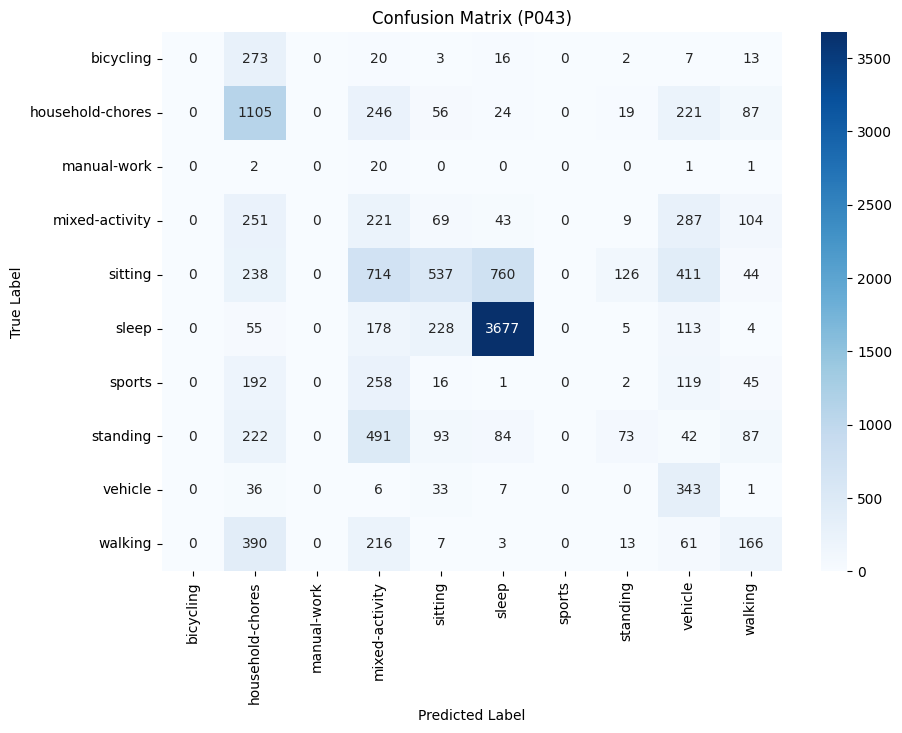

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (P043)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Resumo dos resultados

In [99]:
summary = {
    "test_accuracy": float(test_accuracy),
    "test_loss": float(test_loss),
    "macro_f1": float(macro_f1),
    "f1_per_class": f1_named,
    "confusion_matrix": cm_df
}

In [100]:
print("=== Summary for Participant P043 ===\n")

print(f"Test Accuracy:   {summary['test_accuracy']:.4f}")
print(f"Test Loss:       {summary['test_loss']:.4f}")
print(f"Macro F1:        {summary['macro_f1']:.4f}\n")

print("F1 per class:")
for label, value in summary["f1_per_class"].items():
    print(f"  {label:20s} {value:.4f}")

print("\nConfusion Matrix:")
display(summary["confusion_matrix"])

=== Summary for Participant P043 ===

Test Accuracy:   0.4639
Test Loss:       1.6769
Macro F1:        0.2409

F1 per class:
  bicycling            0.0000
  household-chores     0.4887
  manual-work          0.0000
  mixed-activity       0.1318
  sitting              0.2774
  sleep                0.8286
  sports               0.0000
  standing             0.1089
  vehicle              0.3378
  walking              0.2358

Confusion Matrix:


,bicycling,household-chores,manual-work,mixed-activity,sitting,sleep,sports,standing,vehicle,walking
bicycling,0,273,0,20,3,16,0,2,7,13
household-chores,0,1105,0,246,56,24,0,19,221,87
manual-work,0,2,0,20,0,0,0,0,1,1
mixed-activity,0,251,0,221,69,43,0,9,287,104
sitting,0,238,0,714,537,760,0,126,411,44
sleep,0,55,0,178,228,3677,0,5,113,4
sports,0,192,0,258,16,1,0,2,119,45
standing,0,222,0,491,93,84,0,73,42,87
vehicle,0,36,0,6,33,7,0,0,343,1
walking,0,390,0,216,7,3,0,13,61,166
